In [75]:
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.metrics import mape
from darts.models import TransformerModel
from darts.dataprocessing.transformers import Scaler
from sklearn.preprocessing import MinMaxScaler

import pandas as pd
import numpy as np
from pathlib import Path
import os
from tqdm import tqdm

In [76]:
file_path = Path(os.getcwd()).parents[0]
file_path = Path(file_path, "data", "input", "us3000_tickers_A-B_1min_iqksn", "AA_1min.txt")
print(file_path.absolute())

dataset = pd.read_csv(file_path, names=["Date", "Open", "High", "Low", "Close", "Volume"])
dataset.info()

c:\Users\lucan\Documents\Git Projects\Deep_Learning\data\input\us3000_tickers_A-B_1min_iqksn\AA_1min.txt
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1890108 entries, 0 to 1890107
Data columns (total 6 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Date    object 
 1   Open    float64
 2   High    float64
 3   Low     float64
 4   Close   float64
 5   Volume  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 86.5+ MB


In [77]:
dataset = dataset[["Date","Close"]]
dataset["Date"] = pd.to_datetime(dataset["Date"], format="%Y-%m-%d %H:%M:%S")
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1890108 entries, 0 to 1890107
Data columns (total 2 columns):
 #   Column  Dtype         
---  ------  -----         
 0   Date    datetime64[ns]
 1   Close   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 28.8 MB


In [78]:
dataset.head()

,Date,Close
0,2004-01-02 09:30:00,91.5141
1,2004-01-02 09:31:00,91.6586
2,2004-01-02 09:32:00,91.5863
3,2004-01-02 09:33:00,91.7549
4,2004-01-02 09:34:00,91.8753


In [79]:
dataset = TimeSeries.from_dataframe(dataset, time_col="Date", freq="T", fill_missing_dates=True)

df = dataset.pd_dataframe()
df = df.ffill().bfill()

print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9052470 entries, 2004-01-02 09:30:00 to 2021-03-19 19:59:00
Freq: T
Data columns (total 1 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Close   float64
dtypes: float64(1)
memory usage: 138.1 MB
None


component,Close
Date,
2004-01-02 09:30:00,91.5141
2004-01-02 09:31:00,91.6586
2004-01-02 09:32:00,91.5863
2004-01-02 09:33:00,91.7549
2004-01-02 09:34:00,91.8753


In [80]:
df = df.iloc[::30]
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 301749 entries, 2004-01-02 09:30:00 to 2021-03-19 19:30:00
Freq: 30T
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Close   301749 non-null  float64
dtypes: float64(1)
memory usage: 4.6 MB
None


component,Close
Date,
2004-01-02 09:30:00,91.5141
2004-01-02 10:00:00,91.6104
2004-01-02 10:30:00,91.7308
2004-01-02 11:00:00,92.2125
2004-01-02 11:30:00,92.2366


<Axes: xlabel='Date'>

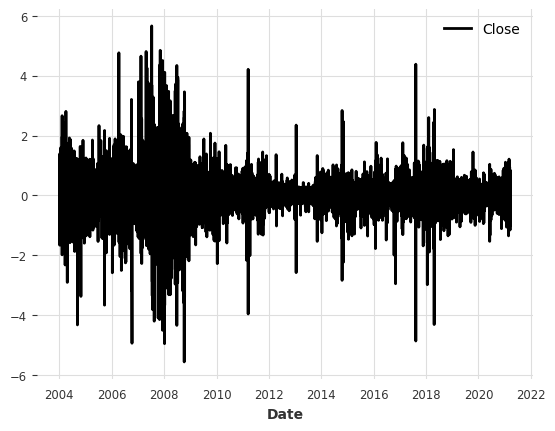

In [81]:
dataset = TimeSeries.from_dataframe(df, value_cols=["Close"])
dataset = dataset.diff()
dataset.plot()

In [82]:
scaler = MinMaxScaler(feature_range=(-1, 1))
transformer = Scaler(scaler)

train, val = dataset.split_after(0.8)

train_scaled = transformer.fit_transform(train)
val_scaled = transformer.transform(val)
dataset_scaled = transformer.transform(dataset)

<Axes: xlabel='Date'>

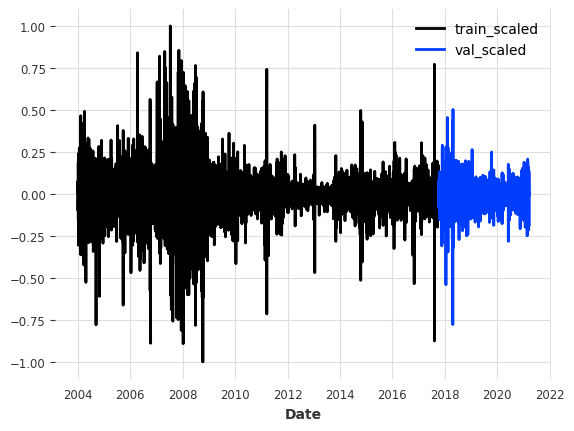

In [83]:
train_scaled.plot(label='train_scaled')
val_scaled.plot(label='val_scaled')

In [84]:
my_model = TransformerModel(
    input_chunk_length=30,
    output_chunk_length=1,
    batch_size=1024,
    n_epochs=100,
    model_name="single_symbol_complete_series_4_diff",
    nhead=8,
    dropout=0.1,
    random_state=42,
    save_checkpoints=True,
    log_tensorboard=True,
    work_dir="../runs"
)

def eval_model(model, series, train, val_series):
    pred_series = model.predict(series=train, n=len(val_series))
    plt.figure(figsize=(8, 5))

    series.plot(label="actual")
    pred_series.plot(label="forecast")
    

    plt.title("MAPE: {:.2f}%".format(mape(pred_series, val_series)))

    plt.legend()
    plt.show()

In [85]:
my_model.fit(series=train_scaled, val_series=val_scaled, verbose=True)

c:\Users\lucan\.conda\envs\dl2\Lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss             | 0     
1 | train_metrics       | MetricCollection    | 0     
2 | val_metrics         | MetricCollection    | 0     
3 | encoder             | Linear              | 128   
4 | positional_encoding | _PositionalEncoding | 0     
5 | transformer    

Epoch 99: 100%|██████████| 236/236 [03:43<00:00,  1.05it/s, v_num=logs, train_loss=0.000485, val_loss=0.00042] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 236/236 [03:43<00:00,  1.05it/s, v_num=logs, train_loss=0.000485, val_loss=0.00042]


TransformerModel(d_model=64, nhead=8, num_encoder_layers=3, num_decoder_layers=3, dim_feedforward=512, dropout=0.1, activation=relu, norm_type=None, custom_encoder=None, custom_decoder=None, input_chunk_length=30, output_chunk_length=1, batch_size=1024, n_epochs=100, model_name=single_symbol_complete_series_4_diff, random_state=42, save_checkpoints=True, log_tensorboard=True, work_dir=../runs)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [06:51<00:00,  0.00it/s]


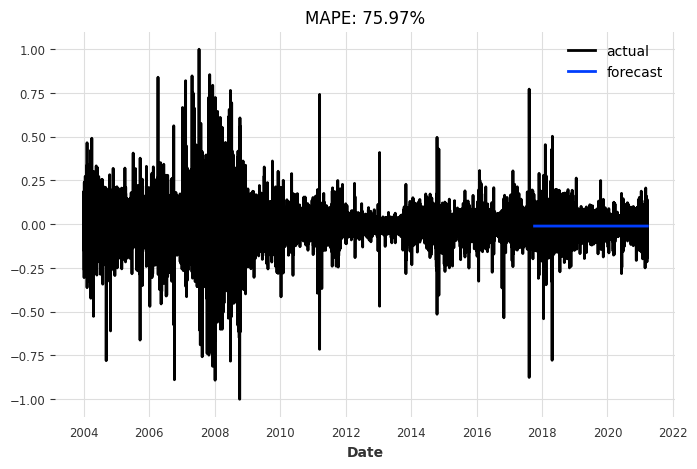

In [86]:
eval_model(my_model, dataset_scaled, train_scaled, val_scaled)